In [14]:
!pip install torch torchaudio
!pip install matplotlib numpy scipy
!pip install IPython
!pip install deep_phonemizer

import torch
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio, display
import warnings
warnings.filterwarnings('ignore')

# GPU 사용 가능 여부 확인
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"PyTorch 버전: {torch.__version__}")
print(f"Torchaudio 버전: {torchaudio.__version__}")
print(f"사용 중인 디바이스: {device}")

  Preparing metadata (setup.py) ... done
  Created wheel for deep_phonemizer: filename=deep_phonemizer-0.0.19-py3-none-any.whl size=33272 sha256=9bcee96180062888e72b86f8e57de562135a5ed45ff63c5c05275919d6628da2
  Stored in directory: /root/.cache/pip/wheels/b9/d7/45/f2ae07184a29327b2a7f93b1f734a936c3a34e57225fca603b
Successfully built deep_phonemizer
PyTorch 버전: 2.8.0+cu126
Torchaudio 버전: 2.8.0+cu126
사용 중인 디바이스: cuda


In [15]:
print("\n========== WaveRNN Vocoder용 모델 로딩 ==========")

# WaveRNN vocoder를 포함한 번들 로드
bundle_wavernn = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

# 텍스트 프로세서 로드
processor_wavernn = bundle_wavernn.get_text_processor()

# Tacotron2 모델 로드
tacotron2_wavernn = bundle_wavernn.get_tacotron2().to(device)

# WaveRNN vocoder 로드
wavernn = bundle_wavernn.get_vocoder().to(device)

print("WaveRNN 모델 로드 완료")


========== WaveRNN Vocoder용 모델 로딩 ==========


100%|██████████| 63.6M/63.6M [00:04<00:00, 13.8MB/s]


Downloading: "https://download.pytorch.org/torchaudio/models/tacotron2_english_phonemes_1500_epochs_wavernn_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/tacotron2_english_phonemes_1500_epochs_wavernn_ljspeech.pth


100%|██████████| 107M/107M [00:00<00:00, 362MB/s]


Downloading: "https://download.pytorch.org/torchaudio/models/wavernn_10k_epochs_8bits_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/wavernn_10k_epochs_8bits_ljspeech.pth


100%|██████████| 16.7M/16.7M [00:00<00:00, 218MB/s]

WaveRNN 모델 로드 완료


In [16]:
print("\n========== Griffin-Lim Vocoder용 모델 로딩 ==========")

# Griffin-Lim vocoder를 포함한 번들 로드
bundle_griffin = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH

# 텍스트 프로세서 로드
processor_griffin = bundle_griffin.get_text_processor()

# Tacotron2 모델 로드
tacotron2_griffin = bundle_griffin.get_tacotron2().to(device)

# Griffin-Lim vocoder 로드
griffin_lim = bundle_griffin.get_vocoder().to(device)

print("Griffin-Lim 모델 로드 완료")


========== Griffin-Lim Vocoder용 모델 로딩 ==========
Downloading: "https://download.pytorch.org/torchaudio/models/tacotron2_english_phonemes_1500_epochs_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/tacotron2_english_phonemes_1500_epochs_ljspeech.pth


100%|██████████| 107M/107M [00:00<00:00, 317MB/s] 


Griffin-Lim 모델 로드 완료


In [17]:
print("\n========== WaveGlow Vocoder 로딩 ==========")

# WaveGlow는 PyTorch Hub에서 별도로 로드한다.
waveglow = torch.hub.load(
    'NVIDIA/DeepLearningExamples:torchhub',
    'nvidia_waveglow',
    model_math='fp32',
    pretrained=False
)

# 사전 학습된 가중치 다운로드
checkpoint = torch.hub.load_state_dict_from_url(
    'https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth',
    progress=True,
    map_location=device
)

# 가중치 로드
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}
waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

print("WaveGlow 모델 로드 완료")


========== WaveGlow Vocoder 로딩 ==========


Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Downloading: "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth" to /root/.cache/torch/hub/checkpoints/nvidia_waveglowpyt_fp32_20190306.pth


100%|██████████| 1.00G/1.00G [00:09<00:00, 111MB/s]


WaveGlow 모델 로드 완료


In [18]:
# 자기소개 텍스트 정의
text = "Hello, I'm Jung Saeyeon, a junior in the Department of Software at university. I'm passionate about front-end development and mainly work with React."
print(f"\n입력 텍스트: {text}\n")


입력 텍스트: Hello, I'm Jung Saeyeon, a junior in the Department of Software at university. I'm passionate about front-end development and mainly work with React.



========== WaveRNN Vocoder ==========
WaveRNN 오디오 shape: (215050,)
샘플링 레이트: 22050 Hz
WaveRNN 결과 저장 완료: output_wavernn.wav



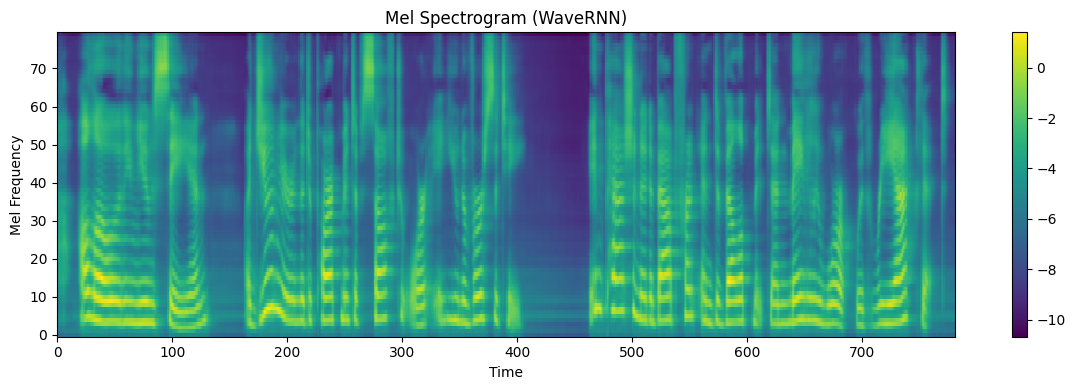

In [19]:
print("========== WaveRNN Vocoder ==========")
# WaveRNN은 구글 코랩 환경에서 정상 작동한다.

with torch.inference_mode():
    # 텍스트를 시퀀스로 변환
    processed, lengths = processor_wavernn(text)
    processed = processed.to(device)
    lengths = lengths.to(device)

    # 멜 스펙트로그램 생성
    spec, spec_lengths, _ = tacotron2_wavernn.infer(processed, lengths)

    # WaveRNN으로 오디오 생성
    waveforms_wavernn, _ = wavernn(spec, spec_lengths)

# 오디오를 numpy 배열로 변환 및 정규화
audio_wavernn = waveforms_wavernn[0].cpu().numpy()
audio_wavernn = audio_wavernn / np.max(np.abs(audio_wavernn))

# 오디오 파일 저장
import scipy.io.wavfile as wavfile
wavfile.write('output_wavernn.wav', wavernn.sample_rate, audio_wavernn)

print(f"WaveRNN 오디오 shape: {audio_wavernn.shape}")
print(f"샘플링 레이트: {wavernn.sample_rate} Hz")
print("WaveRNN 결과 저장 완료: output_wavernn.wav\n")

# 오디오 재생
display(Audio(audio_wavernn, rate=wavernn.sample_rate))

# 멜 스펙트로그램 시각화
plt.figure(figsize=(12, 4))
plt.imshow(spec[0].cpu().numpy(), aspect='auto', origin='lower', interpolation='none')
plt.colorbar()
plt.title('Mel Spectrogram (WaveRNN)')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')
plt.tight_layout()
plt.show()

In [20]:
print("========== Griffin-Lim Vocoder ==========")
# Griffin-Lim은 모든 OS에서 작동한다.

with torch.inference_mode():
    # 텍스트를 시퀀스로 변환
    processed, lengths = processor_griffin(text)
    processed = processed.to(device)
    lengths = lengths.to(device)

    # 멜 스펙트로그램 생성
    spec_griffin, spec_lengths_griffin, _ = tacotron2_griffin.infer(processed, lengths)

    # Griffin-Lim으로 오디오 생성
    waveforms_griffin, _ = griffin_lim(spec_griffin, spec_lengths_griffin)

# 오디오를 numpy 배열로 변환 및 정규화
audio_griffin = waveforms_griffin[0].cpu().numpy()
audio_griffin = audio_griffin / np.max(np.abs(audio_griffin))

# 오디오 파일 저장
wavfile.write('output_griffin_lim.wav', griffin_lim.sample_rate, audio_griffin)

print(f"Griffin-Lim 오디오 shape: {audio_griffin.shape}")
print(f"샘플링 레이트: {griffin_lim.sample_rate} Hz")
print("Griffin-Lim 결과 저장 완료: output_griffin_lim.wav\n")

# 오디오 재생
display(Audio(audio_griffin, rate=griffin_lim.sample_rate))

========== Griffin-Lim Vocoder ==========
Griffin-Lim 오디오 shape: (200704,)
샘플링 레이트: 22050 Hz
Griffin-Lim 결과 저장 완료: output_griffin_lim.wav



In [21]:
print("========== WaveGlow Vocoder ==========")

# Griffin-Lim에서 생성한 멜 스펙트로그램을 재사용한다.
with torch.no_grad():
    # WaveGlow로 오디오 생성
    waveforms_waveglow = waveglow.infer(spec_griffin)

# 오디오를 numpy 배열로 변환 및 정규화
audio_waveglow = waveforms_waveglow[0].cpu().numpy()
audio_waveglow = audio_waveglow / np.max(np.abs(audio_waveglow))

# 오디오 파일 저장
wavfile.write('output_waveglow.wav', 22050, audio_waveglow)

print(f"WaveGlow 오디오 shape: {audio_waveglow.shape}")
print(f"샘플링 레이트: 22050 Hz")
print("WaveGlow 결과 저장 완료: output_waveglow.wav\n")

# 오디오 재생
display(Audio(audio_waveglow, rate=22050))


========== WaveGlow Vocoder ==========
WaveGlow 오디오 shape: (200960,)
샘플링 레이트: 22050 Hz
WaveGlow 결과 저장 완료: output_waveglow.wav



========== Vocoder 결과 비교 ==========



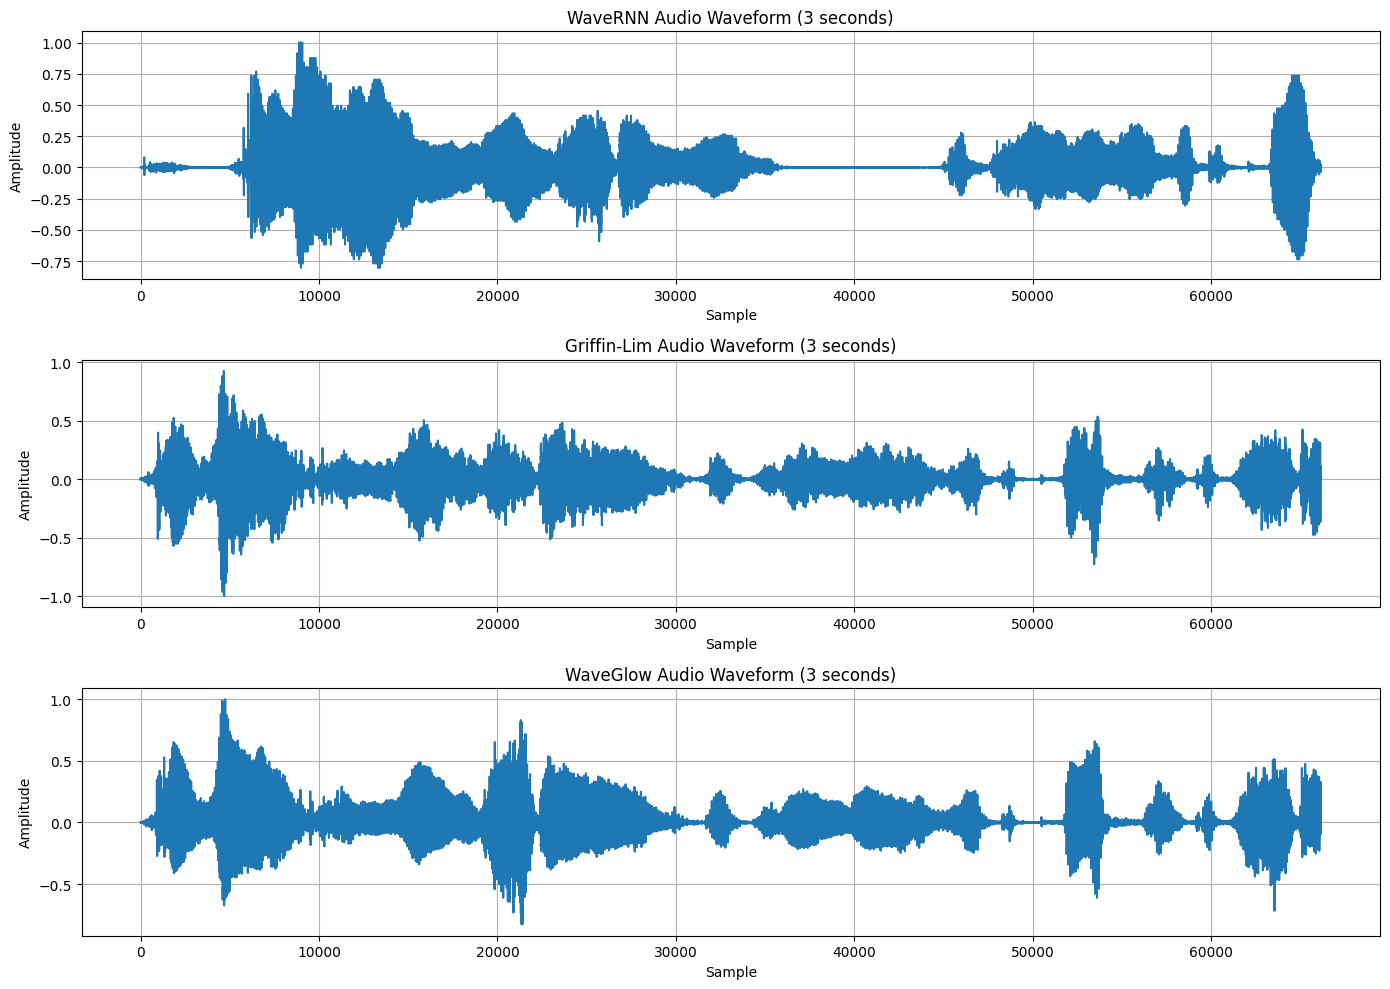

In [23]:
print("========== Vocoder 결과 비교 ==========\n")

# 파형 시각화
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# WaveRNN 파형
axes[0].plot(audio_wavernn[:wavernn.sample_rate*3])
axes[0].set_title('WaveRNN Audio Waveform (3 seconds)')
axes[0].set_xlabel('Sample')
axes[0].set_ylabel('Amplitude')
axes[0].grid(True)

# Griffin-Lim 파형
axes[1].plot(audio_griffin[:griffin_lim.sample_rate*3])
axes[1].set_title('Griffin-Lim Audio Waveform (3 seconds)')
axes[1].set_xlabel('Sample')
axes[1].set_ylabel('Amplitude')
axes[1].grid(True)

# WaveGlow 파형
axes[2].plot(audio_waveglow[:22050*3])
axes[2].set_title('WaveGlow Audio Waveform (3 seconds)')
axes[2].set_xlabel('Sample')
axes[2].set_ylabel('Amplitude')
axes[2].grid(True)

plt.tight_layout()
plt.show()